In [ ]:
# Imports

import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import time

# for RAM managment
import gc
import sys



## 1. The file is loaded and some features are calculated.


In [ ]:
#audio_filename = '/content/drive/MyDrive/TFG/Marco Mezquida DB/test.wav'
audio_filename = '/content/drive/MyDrive/TFG/synthetic_data/mixed.wav'
boundaries_file = '/content/drive/MyDrive/TFG/synthetic_data/boundaries_mixed.txt'


signal, sample_rate = librosa.load(audio_filename, mono = True)
duration = len(signal) / sample_rate 
duration


579.4484353741497

## 2. Points where the boundarie should be detected

In [ ]:
# segment_boundaries = [10, 20, 30, 40, 50, 54]   # in sec        FOR THE test.wav FILE
with open(boundaries_file) as file:
    segment_boundaries = [round(float(line.rstrip('\n')), 3) for line in file]

margin = 0.5           # in sec; 200 ms 
len(segment_boundaries)

60

## 2.1 Evaluation sampled signal

In [ ]:
annotation_vector = []

duration_ms = int(np.ceil(duration*1000))# we need to process it in miliseconds
periode = int((margin*1000)*2)
#print(str(periode) + 'ms')
#print(str(duration_ms) + 'ms')

# we want the annotated boundaries to be in the center of the periodes, therefore we need the first periode to be 250ms and all the others 500ms.

for i in range(0, duration_ms, periode):
  if True in (i-periode/2 <= x*1000 < i + periode/2 for x in segment_boundaries):
    annotation_vector.append(True)
  else:
    annotation_vector.append(False)


# 3. Real Time Algorithm

In [ ]:
#@title
def RealTimeSegmentation(signal, sample_rate, listened_duration, detection_delay, detected_peaks, max_length, tstep):

  start_time = time.time()


  FFT_size = 8192
  N_mel_filt = 40
  N_mel_coef = 20
  Kernel_size = 84
  offset = 0.45
  medi_filter_size = 83

  duration = len(signal) / sample_rate


  # Constant parameters
  w = np.hamming(FFT_size)    # Hamming window


  S = librosa.feature.melspectrogram(signal, sr = sample_rate, n_fft = FFT_size, window = w, n_mels = N_mel_filt)
  db_S = librosa.amplitude_to_db(S, ref=np.max)


  mfcc = librosa.feature.mfcc(S = db_S, n_mfcc = N_mel_coef)

  #D = scipy.spatial.distance.pdist(mfcc.T, metric = "canberra")
  #D = scipy.spatial.distance.pdist(mfcc.T, metric = "cosine")
  D = scipy.spatial.distance.pdist(mfcc.T, metric = "correlation")

  SSM = scipy.spatial.distance.squareform(D)
  SSM /= D.max()  


  # Gaussian vector
  g = scipy.signal.gaussian(M = Kernel_size, std = Kernel_size/3, sym=True)
  # 3D Gaussian 
  G = np.dot(g.reshape(-1, 1), g.reshape(1, -1))
  # dividing the 3D Gaussian matrix into 4 squares and multiplying -1 and +1
  G[Kernel_size//2:, :Kernel_size//2] = -G[Kernel_size//2:, :Kernel_size//2]
  G[:Kernel_size//2, Kernel_size//2:] = -G[:Kernel_size//2, Kernel_size//2:]


  novelty_curve = np.zeros(SSM.shape[1])

  N = SSM.shape[0]
  L = G.shape[0]

  for i in range( L//2, N - L//2 + 1):
    novelty_curve[i] = np.sum(SSM[i - L//2:i + L//2, i - L//2:i + L//2] * G)
    # If this is carashing, your L is an odd number, therefore the broadcast crahes since // returns a rounded down number
        
  novelty_curve = np.abs(novelty_curve)

  # Normalize
  novelty_curve += novelty_curve.min()
  novelty_curve /= novelty_curve.max()


  time_axis = np.linspace(0, duration, len(novelty_curve))


  # Peak detection algorithm 
    # in the paper theres another algorithm, maybe try it
  threshold = scipy.ndimage.filters.median_filter(novelty_curve, size = medi_filter_size) + novelty_curve.mean()*offset
  peaks = []

  for i in range(1, novelty_curve.shape[0] - 1):
      # is it a peak?
    if novelty_curve[i - 1] < novelty_curve[i] and novelty_curve[i] > novelty_curve[i + 1]:
      # is it above the threshold?
      if novelty_curve[i] > threshold[i]:
        if(tstep and listened_duration > max_length):
          peaks.append(i + max_length)
        else:
          peaks.append(i)



  if listened_duration <= max_length:
    peaks = np.array(peaks)*(duration/len(novelty_curve))
  else:
    peaks = np.array(peaks)*(duration/len(novelty_curve)) + (listened_duration-max_length - detection_delay)








  # Force python to free RAM after each exec
  del D
  del SSM
  gc.collect()


  # Output in real time execution
  print('Length analyzed: ' + str(len(signal)/sample_rate) + '\t Time location: ' + str(listened_duration) + '\t Execution time: ' + str(time.time() - start_time))
  
  # Detection of new transition between segments
  
  for peak in peaks:
    if peak > (listened_duration - detection_delay):
      print( 'Boundrie estimatation at: ' + str(peak) + 'sec')
      detected_peaks.append(peak)
  print('\n')

  return (time.time() - start_time)


In [ ]:
#listened_duration = 540 # se deberia pasar por parametro, corresponde a la duracin acumulada en el instante

time_of_start = 10   #seconds
time_step = 1        #seconds
detection_delay = 1  #seconds

max_length = 80     #seconds

# data for results
detected_peaks = []



# We process an evolving chunk of the signal to simulate real-time processing.
for listened_duration in range(time_of_start, round(duration) + time_step, time_step):
  if listened_duration - max_length <= 0:
    RealTimeSegmentation(signal[:listened_duration*sample_rate], sample_rate, listened_duration, detection_delay, detected_peaks, max_length, False)
  else:
    RealTimeSegmentation(signal[(listened_duration - max_length)*sample_rate : listened_duration*sample_rate], sample_rate, listened_duration, detection_delay, detected_peaks, max_length, True)

"""

# Processing all the past
time_exe = []
for listened_duration in range(time_of_start, round(duration) + time_step, time_step):
  exec_time = RealTimeSegmentation(signal[:listened_duration*sample_rate], sample_rate, listened_duration, detection_delay, detected_peaks, max_length, False)
  time_exe.append([listened_duration, exec_time])

"""

# 3.1 Evaluation of results

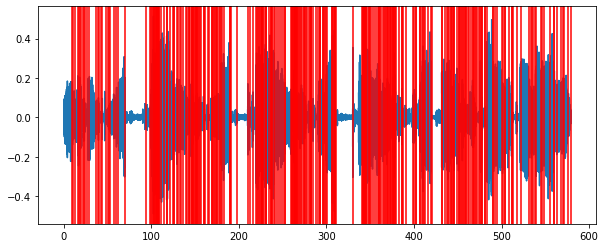

Number of peaks estimated: 305


In [ ]:
# plot of peaks
time_axis = np.linspace(0, duration, len(signal))

plt.figure(1, figsize=(10, 4))
plt.plot(time_axis, signal)
for peak in detected_peaks:
    plt.axvline(peak, color="r")
plt.show()
print('Number of peaks estimated: ' + str(len(detected_peaks)))


In [ ]:
# SCORING COMPUTATION

# We create a vector like the evaluation vector, but allocating the boundaries estimated.
estimation_vector = [False] * len(annotation_vector)

# First shorter period
if True in (0 <= x*1000 < periode//2 for x in detected_peaks):
  estimation_vector[0] = True

# all the rest
for i in range(0, duration_ms, periode):# we need to process it in miliseconds
  if True in (i-periode/2 <= x*1000 < i + periode/2 for x in detected_peaks):
    estimation_vector[i//periode] = True



# Using the confusion matrix and its metrics, we asign a score
# True Positive   ->   An annotated boundarie aligns with one (or more) peaks       ->  True - True     ->  AND
# True Negative   ->   A period without annotations aligns with NO peaks            ->  False - False   ->  NOT(OR)
# False Negative  ->   An annotated boundarie aligns with NO peaks                  ->  True - False    ->  Abjunction (Material nonimplication)
# False Positive  ->   A period without annotations aligns with a peak              ->  False - True    ->  N peaks - TP)

tp_vector = [False] * len(annotation_vector)
tn_vector = [False] * len(annotation_vector)
fn_vector = [False] * len(annotation_vector)
fp_vector = [False] * len(annotation_vector)
for i in range(0, len(annotation_vector)):
  tp_vector[i] = annotation_vector[i] and estimation_vector[i]
  tn_vector[i] = not(annotation_vector[i] or estimation_vector[i])
  fn_vector[i] = annotation_vector[i] and not(estimation_vector[i])
  fp_vector[i] = estimation_vector[i] and not(annotation_vector[i])


TP = sum(tp_vector)
TN = sum(tn_vector)
FN = sum(fn_vector)
FP = sum(fp_vector)

# FN = [(annotation_vector[i] and not(estimation_vector[i])) for i in range(0, len(annotation_vector))]

if len(detected_peaks) == 0:
  recall = 0
  TNR = 0
  precision = 0
  false_positive_rate = 1
  Fscore = 0
else:
  recall = TP / (TP + FN)         # sensitivity, recall, hit rate, or true positive rate (TPR)
  TNR = TN / (TN + FP)          # specificity, selectivity or true negative rate (TNR)

  precision = TP / (TP + FP)    # precision or positive predictive value (PPV)  -> BETTER FOR IMBALANCED DATASETS WITH MORE NEGATIVE SAMPLES  

  false_positive_rate = FP / (FP + TN)      # fall-out or false positive rate (FPR)

  Fscore = (2*TP) / (2*TP + FP + FN)      # F1 score - is the harmonic mean of precision and sensitivity:


confM = [TP, TN, FN, FP]

#results_dict[fft_iter][filt_iter][coef_iter][kern_iter][offset_iter][mfilter_iter] = [precision, recall, TNR, false_positive_rate]
print('Precision: \t'+ str(precision))
print('Fscore: \t'+ str(Fscore))
print('Confusion Matrix: [TP, TN, FN, FP] = ' + str(confM))
print('Correct detections: \t' + str(TP/len(segment_boundaries)) + '%')

Precision: 	0.13692946058091288
Fscore: 	0.21926910299003322
Confusion Matrix: [TP, TN, FN, FP] = [33, 312, 27, 208]
Correct detections: 	0.55%


# Execution time vs. length graph

Text(30, 10, '58s')

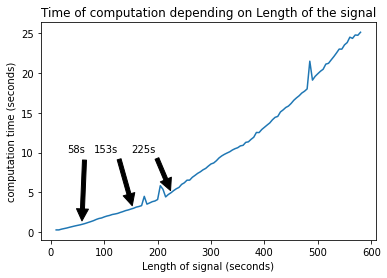

In [ ]:
# graph of execution time vs length of the signal
durations = []
executions_t = []
results = pd.DataFrame(columns = ['Signal Length', 'Computation Time'])
for inpu in time_exe:
  durations.append(inpu[0])
  executions_t.append(inpu[1])
  results.loc[len(results), :] = [inpu[0], inpu[1]]

results.to_csv('/content/drive/MyDrive/TFG/_5sec_ComplPast.csv', sep=',')

plt.plot(durations, executions_t)
plt.title('Time of computation depending on Length of the signal')
plt.xlabel('Length of signal (seconds)')
plt.ylabel('computation time (seconds)')

xval=np.interp(5, executions_t, durations)

plt.annotate(str(int(xval)) + 's', (xval, 5), xytext=(150, 10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

xval=np.interp(3, executions_t, durations)
plt.annotate(str(int(xval)) + 's', (xval, 3), xytext=(80, 10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

xval=np.interp(1, executions_t, durations)
plt.annotate(str(int(xval)) + 's', (xval, 1), xytext=(30, 10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )